In [ ]:
#%pip install --user timm

In [2]:
#!pip show timm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts')
print(sys.path)
import DataCore_Akhil as DC
import AkhilFunctions as AF
import auxiliary_functions as af
import plotting

import torch
print(f"{torch.cuda.is_available()} good")
print(f"{torch.cuda.device_count()} devices")
print(torch.cuda.mem_get_info())

from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset, Subset, ConcatDataset
from astropy.io import fits
import torchvision
import timm
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

['/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Notebooks', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python311.zip', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/lib-dynload', '', '/Users/users/mahesh/.local/lib/python3.11/site-packages', '/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages', '/net/virgo01/data/users/mahesh/DeepLearning/DLP_galaxy_mergers/Scripts']
True good
1 devices
(19592773632, 25339101184)


In [5]:
#torch.cuda.memory_summary()

In [6]:
datadir = "/net/virgo01/data/users/mahesh/DeepLearning/data/"
labeldir = "/net/virgo01/data/users/spirov/Deep/catalog_tng100_jwst_all_50sns.fits"
labels = fits.open(labeldir)[1]

In [7]:
with fits.open(datadir + "mock_v4/F150W/L75n1820TNG/snapnum_053/xy/JWST_50kpc_F150W_TNG100_sn053_xy_broadband_1.fits") as hdu1:
    print(hdu1[0].shape)

(1, 256, 256)


In [8]:
mask1 = labels.data['is_major_merger'] == 0
mask2 = labels.data['is_pre_merger'] == 0
mask3 = labels.data['is_ongoing_merger'] == 1
mask4 = labels.data['is_post_merger'] == 0
#print(len(labels.data[mask1 & mask2 & mask3 & mask4]))
#print(len(labels.data[mask1]))

major: 2383

pre only: 1236\
ongoing only: 511\
post only: 605\
pre and post: 31\
sum: 2383
31

# DeiT III

In [9]:
swin_multi = timm.create_model('deit3_large_patch16_224', pretrained=True, num_classes=3)

# Freeze all parameters first
for param in swin_multi.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi.head.parameters():
    param.requires_grad = True
    #print('yay')

config = timm.data.resolve_model_data_config(swin_multi)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi = swin_multi.to(device)

In [10]:
swin_multi.head

Linear(in_features=1024, out_features=3, bias=True)

In [11]:
config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [12]:
# Validation/test transform without augmentations
val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=config["mean"], std=config["std"])
])

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [13]:
nonmerger_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(15), #degrees=(0, 360)
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #add_noise,
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

In [14]:
merger_transform = transforms.Compose([
    transforms.Lambda(lambda img: af.aggressive_arcsinh_scaling(img)),
    transforms.Lambda(lambda img: img.squeeze(0) if img.shape[0] == 1 else img),
    transforms.ToPILImage(),
    transforms.Resize(config["input_size"][1:]),  # Resize to model's expected input size
    #transforms.RandomResizedCrop(256, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(0, 360)), #degrees=(0, 360)
    transforms.Grayscale(num_output_channels=3),   # Convert grayscale to 3 channels
    transforms.ToTensor(),
    #add_noise,
    transforms.Normalize(mean=config["mean"], std=config["std"])  # Use model-specific normalization
])

In [15]:
swin_multidata = DC.nonbinary_ClassificationDataset_v2(datadir, labels, nonmerger_transform = nonmerger_transform, merger_transform = merger_transform)

In [16]:
strat_labels = np.empty(len(labels.data), dtype = int)
mask_pre = labels.data['is_pre_merger'] == 1
mask_post = labels.data['is_post_merger'] == 1
mask_ongoing = labels.data['is_ongoing_merger'] == 1
mask_non = labels.data['is_major_merger'] == 0

strat_labels[mask_pre] = 1
strat_labels[mask_post | mask_ongoing] = 2
strat_labels[mask_non] = 0
strat_labels[mask_pre & mask_post] = 3

In [17]:
# Assume strat_labels is a NumPy array with your labels.
all_indices = np.arange(len(swin_multidata))
print(len(all_indices))
print(len(strat_labels))

# Remove labels with 3 (i.e. samples to be ignored)
noneMask = (strat_labels != 3)
filtered_all_indices = all_indices[noneMask]
filtered_strat_labels = strat_labels[noneMask]

print(len(filtered_all_indices))
print(len(filtered_strat_labels))

# Create relative indices for the filtered dataset
relative_indices = np.arange(len(filtered_strat_labels))

# First split: 80% train, 20% temporary
train_idx_rel, temp_idx_rel = train_test_split(
    relative_indices, test_size=0.20, stratify=filtered_strat_labels, random_state=42
)

# Map the relative indices back to the original indices
train_idx = filtered_all_indices[train_idx_rel]
temp_idx = filtered_all_indices[temp_idx_rel]

train_strat_labels = filtered_strat_labels[train_idx_rel]
first_train_strat_labels = train_strat_labels

desample_factor = 0.9
augmentation_factor = 3

# For the temporary set, get its stratification labels (relative indices)
temp_strat_labels = filtered_strat_labels[temp_idx_rel]

# Second split: split temp indices equally into validation and test sets
val_idx_rel, test_idx_rel = train_test_split(
    temp_idx_rel, test_size=0.5, stratify=filtered_strat_labels[temp_idx_rel], random_state=42
)

# Map these relative indices back to the original indices
val_idx = filtered_all_indices[val_idx_rel]
test_idx = filtered_all_indices[test_idx_rel]

# Create the Subset datasets (using your custom SubsetWithTransform for validation and test)
swin_multi_train_dataset = Subset(swin_multidata, train_idx)
swin_multi_val_dataset = AF.SubsetWithTransform_v2(swin_multidata, val_idx, transform=val_test_transform)
swin_multi_test_dataset = AF.SubsetWithTransform_v2(swin_multidata, test_idx, transform=val_test_transform)

58436
58436
58405
58405


In [18]:
#if I want to include the label 3 data in test and validation

# # Step 1: Create full indices and strat_labels (as you already do)
# all_indices = np.arange(len(swin_multidata))
# print("Full dataset size:", len(all_indices))
# print("Strat labels size:", len(strat_labels))

# # Step 2: Split the entire dataset into training (80%) and temporary (20%) using full strat_labels
# train_idx, temp_idx = train_test_split(
#     all_indices, test_size=0.20, stratify=strat_labels, random_state=42
# )

# # Step 3: For the training set, remove the samples with label 3 (pre+post mergers)
# train_idx = train_idx[strat_labels[train_idx] != 3]
# print("Training set size after filtering label 3:", len(train_idx))

# # Step 4: For validation/test, use the temporary indices as is (which still include label 3)
# temp_strat_labels = strat_labels[temp_idx]
# # Now split temp equally into validation and test, with stratification on the full labels (including label 3)
# val_idx, test_idx = train_test_split(
#     temp_idx, test_size=0.5, stratify=temp_strat_labels, random_state=42
# )

# # Create the Subset datasets
# swin_multi_train_dataset = Subset(swin_multidata, train_idx)
# swin_multi_val_dataset = AF.SubsetWithTransform_v2(swin_multidata, val_idx, transform=val_test_transform)
# swin_multi_test_dataset = AF.SubsetWithTransform_v2(swin_multidata, test_idx, transform=val_test_transform)

In [19]:
all_indices = np.arange(len(swin_multi_train_dataset))

# Create a boolean mask for the majority class (0,0)
mask_majority = train_strat_labels == 0
majority_indices = all_indices[mask_majority]

# Downsample the (0,0) samples to 80% of their original count
new_majority_indices = np.random.choice(majority_indices, 
                                          size=int(desample_factor * len(majority_indices)), 
                                          replace=False)

# For the minority classes, keep all indices
minority_indices = all_indices[~mask_majority]

# Combine the indices and optionally shuffle them
new_indices = np.concatenate([new_majority_indices, minority_indices])
np.random.shuffle(new_indices)

train_strat_labels = train_strat_labels[new_indices]

# Create a new Subset dataset with the new indices
swin_multi_train_dataset = Subset(swin_multi_train_dataset, new_indices)

In [20]:
len(swin_multi_train_dataset)

42239

In [21]:
# Create a boolean mask for minority samples (i.e., not [0,0])
minority_mask = ~(train_strat_labels == 0)
minority_indices = np.where(minority_mask)[0].tolist()

# Create a subset for the minority samples
minority_dataset = Subset(swin_multi_train_dataset, minority_indices)

# Concatenate the original dataset with the minority subset (doubling the minority samples)
for i in range(augmentation_factor-1):
    swin_multi_train_dataset = ConcatDataset([swin_multi_train_dataset, minority_dataset])

In [22]:
len(swin_multi_train_dataset)

46003

In [23]:
# train_size = int(0.81 * len(swin_multidata))
# val_size = int(0.09*len(swin_multidata))
# test_size = len(swin_multidata) - train_size - val_size
# swin_multi_train_dataset, swin_multi_val_dataset, swin_multi_test_dataset = random_split(swin_multidata, [train_size, val_size, test_size])

batch_size = 128
num_workers = 4
prefetch_factor = 2
persistent_workers = True
swin_multi_train_loader = DataLoader(swin_multi_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                          pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_val_loader = DataLoader(swin_multi_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                        pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)
swin_multi_test_loader = DataLoader(swin_multi_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                         pin_memory=True, persistent_workers=persistent_workers, prefetch_factor = prefetch_factor)

# x,y = next(iter(swin_multi_train_loader))
# print("x batch shape:", x.shape)  # Should be [batch_size, 3, 224, 224]
# print("y batch shape:", y.shape)  # Should be [batch_size, 3]

In [24]:
weight = torch.tensor([0.5,10,10], dtype=torch.float32, device = device)
N = len(swin_multi_train_dataset)
n1 = np.sum((train_strat_labels == 1))*1.5#*augmentation_factor
n2 = np.sum((train_strat_labels == 2))*1.53#*augmentation_factor
n0 = np.sum((train_strat_labels == 0))*0.85#*desample_factor
C=3
w0 = N / (C * n0)
w1 = N / (C * n1)
w2 = N / (C * n2)

# weight = torch.tensor([0.5,10,10], dtype=torch.float32, device = device)
# N = len(swin_multi_train_dataset)
# n1 = np.sum((train_strat_labels == 1))*1.4#*augmentation_factor
# n2 = np.sum((train_strat_labels == 2))*1.2#*augmentation_factor
# n0 = np.sum((train_strat_labels == 0))*0.9#*desample_factor
# C=3
# w0 = N / (C * n0)
# w1 = N / (C * n1)
# w2 = N / (C * n2)

weight = torch.tensor([0.7,w1,w2], dtype=torch.float32, device = device)
criterion = nn.CrossEntropyLoss(weight=weight)
#optimizer = optim.Adam(swin_multi.parameters(), lr=0.005, weight_decay=1e-4)
optimizer = optim.AdamW(swin_multi.parameters(),
                        lr=1e-4,            # learning rate, adjust as needed
                        betas=(0.9, 0.999), # momentum parameters
                        eps=1e-8,           # term added to improve numerical stability
                        weight_decay=0.01)  # decoupled weight decay

In [25]:
print(n0,n1,n2)
print(w0,w1,w2)
print(weight)

34303.45 1483.5 1366.29
0.4470201490909321 10.336591394225367 11.223337163657302
tensor([ 0.7000, 10.3366, 11.2233], device='cuda:0')


In [26]:
epochs = 50
num_training_steps = epochs*len(swin_multi_train_loader)  # total steps (epochs * batches_per_epoch)
num_warmup_steps = int(0.05*num_training_steps)
scheduler = AF.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

Epoch 1/50 - Learning Rate: 0.000000


Training:   0%|                                                                                 | 0/360 [00:00<?, ?it/s]/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 1.040851 | Val Loss: 0.899874 | Val Acc: 0.728 | Balanced Acc: 0.604
Epoch 1/50 took 310.91 seconds
Epoch 2/50 - Learning Rate: 0.000040


Train Loss: 0.858178 | Val Loss: 0.699057 | Val Acc: 0.816 | Balanced Acc: 0.674
Epoch 2/50 took 309.45 seconds
Epoch 3/50 - Learning Rate: 0.000080


Train Loss: 0.746799 | Val Loss: 0.580521 | Val Acc: 0.864 | Balanced Acc: 0.678
Epoch 3/50 took 306.86 seconds


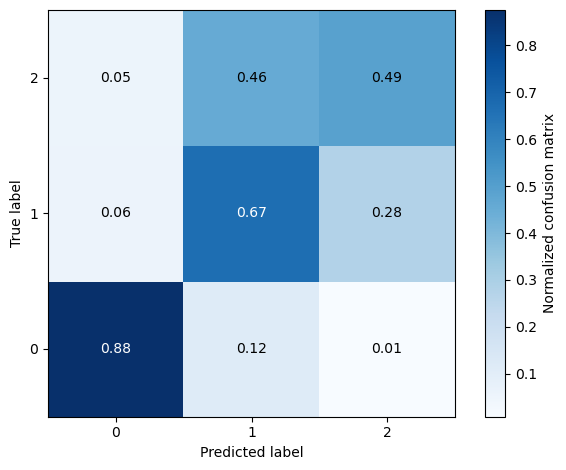

Epoch 4/50 - Learning Rate: 0.000100


Train Loss: 0.688655 | Val Loss: 0.541918 | Val Acc: 0.871 | Balanced Acc: 0.649
Epoch 4/50 took 308.07 seconds


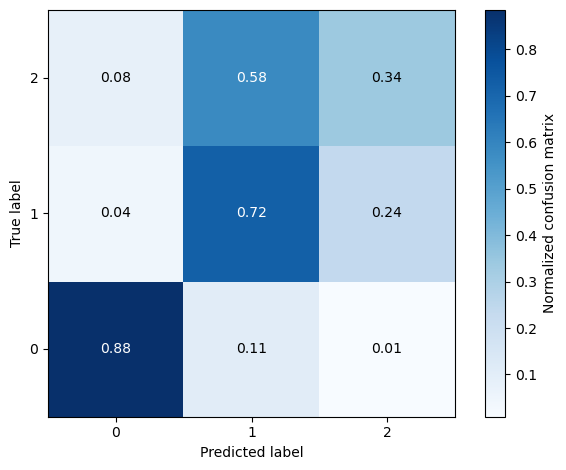

Epoch 5/50 - Learning Rate: 0.000100


Train Loss: 0.661342 | Val Loss: 0.541801 | Val Acc: 0.877 | Balanced Acc: 0.684
Epoch 5/50 took 308.42 seconds


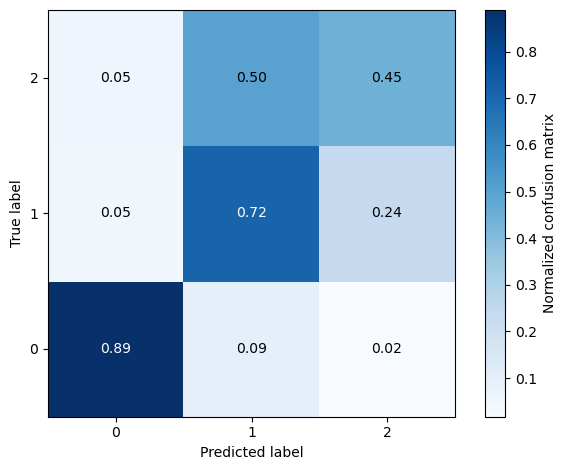

Epoch 6/50 - Learning Rate: 0.000100


Train Loss: 0.648997 | Val Loss: 0.530835 | Val Acc: 0.878 | Balanced Acc: 0.663
Epoch 6/50 took 308.08 seconds


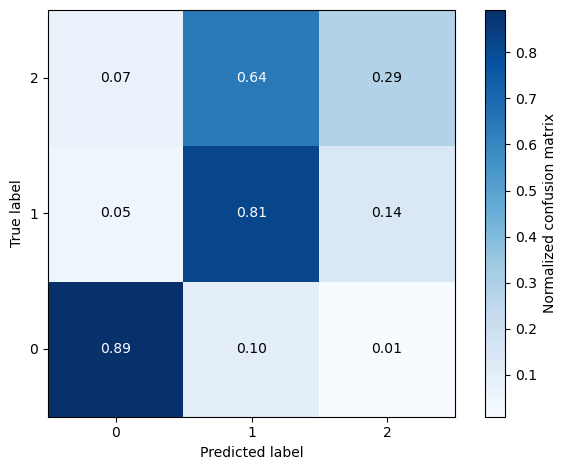

Epoch 7/50 - Learning Rate: 0.000099


Train Loss: 0.631416 | Val Loss: 0.464028 | Val Acc: 0.910 | Balanced Acc: 0.707
Epoch 7/50 took 308.81 seconds


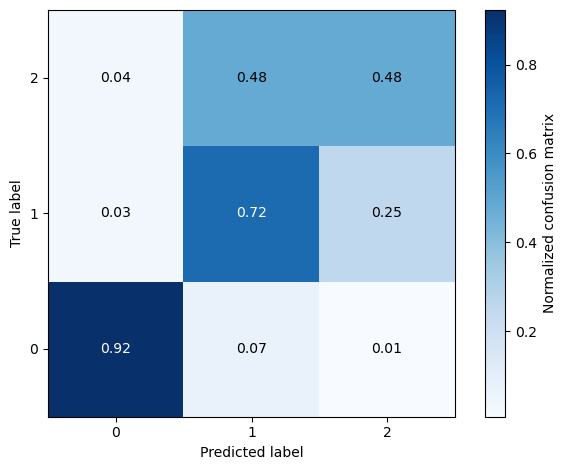

Epoch 8/50 - Learning Rate: 0.000099


Train Loss: 0.608723 | Val Loss: 0.459427 | Val Acc: 0.910 | Balanced Acc: 0.713
Epoch 8/50 took 309.73 seconds


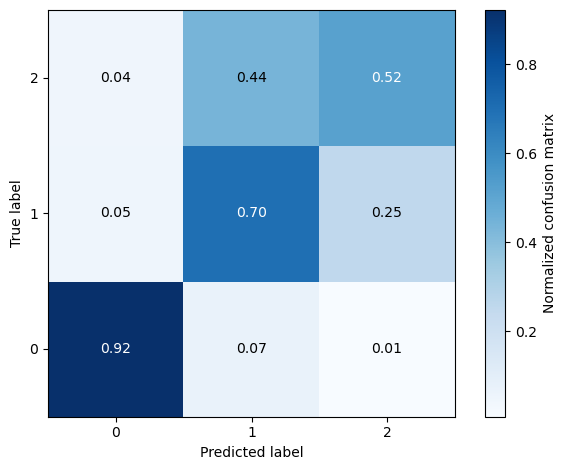

Epoch 9/50 - Learning Rate: 0.000098


Train Loss: 0.602772 | Val Loss: 0.439319 | Val Acc: 0.914 | Balanced Acc: 0.689
Epoch 9/50 took 309.52 seconds


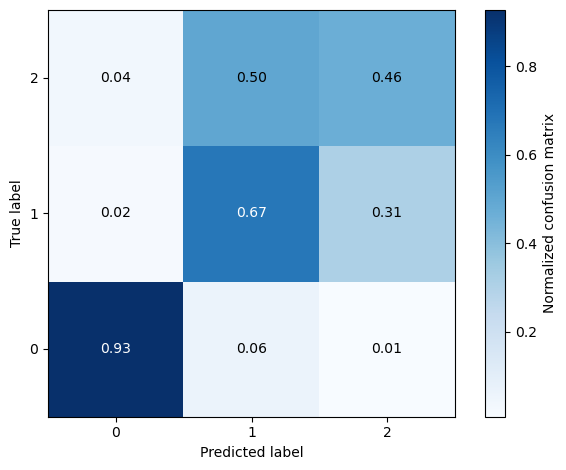

Epoch 10/50 - Learning Rate: 0.000098


Train Loss: 0.592708 | Val Loss: 0.419164 | Val Acc: 0.932 | Balanced Acc: 0.735
Epoch 10/50 took 309.48 seconds


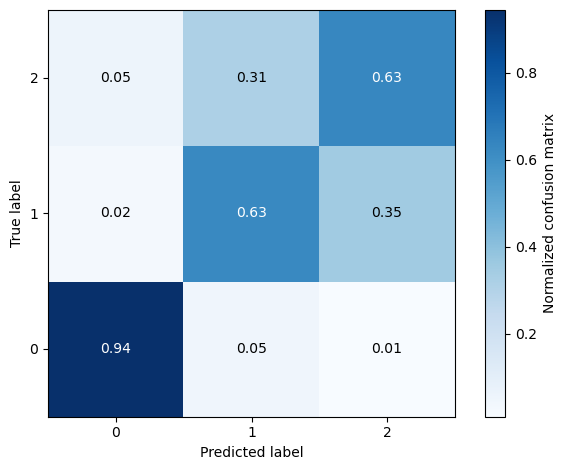

Epoch 11/50 - Learning Rate: 0.000097


Train Loss: 0.582110 | Val Loss: 0.431025 | Val Acc: 0.923 | Balanced Acc: 0.710
Epoch 11/50 took 310.04 seconds


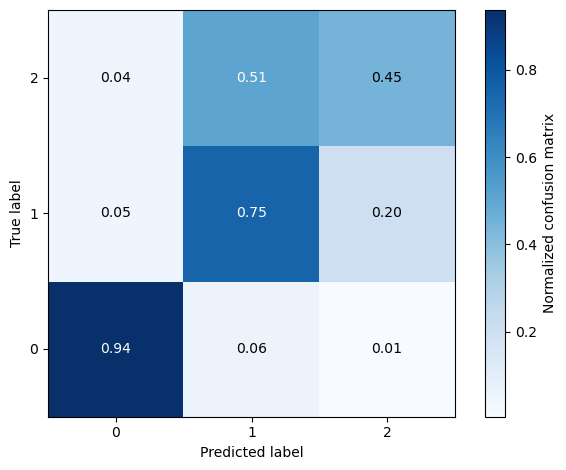

Epoch 12/50 - Learning Rate: 0.000096


Train Loss: 0.578139 | Val Loss: 0.416877 | Val Acc: 0.929 | Balanced Acc: 0.739
Epoch 12/50 took 309.57 seconds


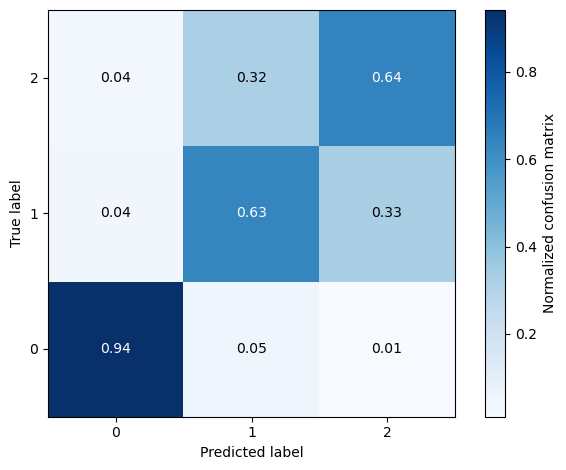

Epoch 13/50 - Learning Rate: 0.000095


Train Loss: 0.568428 | Val Loss: 0.433799 | Val Acc: 0.928 | Balanced Acc: 0.695
Epoch 13/50 took 309.28 seconds


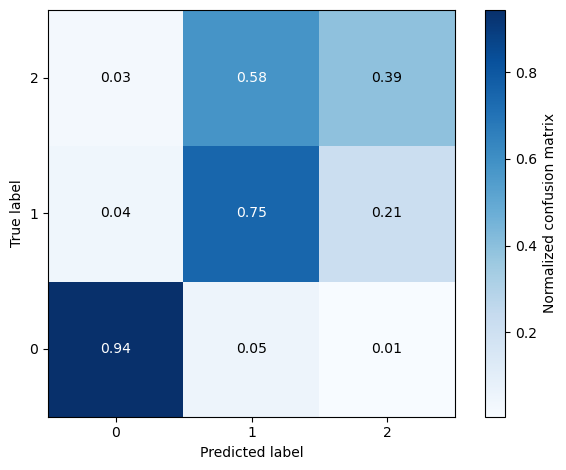

Epoch 14/50 - Learning Rate: 0.000094


Train Loss: 0.567078 | Val Loss: 0.435832 | Val Acc: 0.925 | Balanced Acc: 0.700
Epoch 14/50 took 308.57 seconds


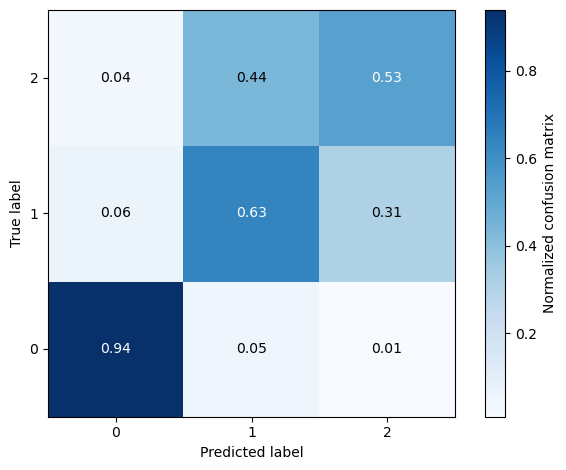

Epoch 15/50 - Learning Rate: 0.000093


Train Loss: 0.561147 | Val Loss: 0.391380 | Val Acc: 0.944 | Balanced Acc: 0.714
Epoch 15/50 took 310.19 seconds


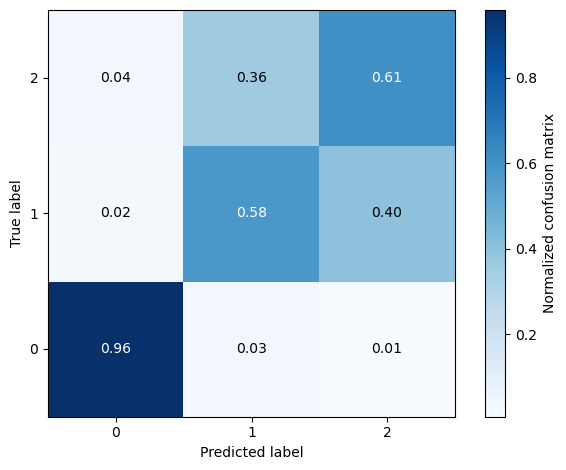

Epoch 16/50 - Learning Rate: 0.000092


Train Loss: 0.560028 | Val Loss: 0.393031 | Val Acc: 0.945 | Balanced Acc: 0.714
Epoch 16/50 took 309.79 seconds


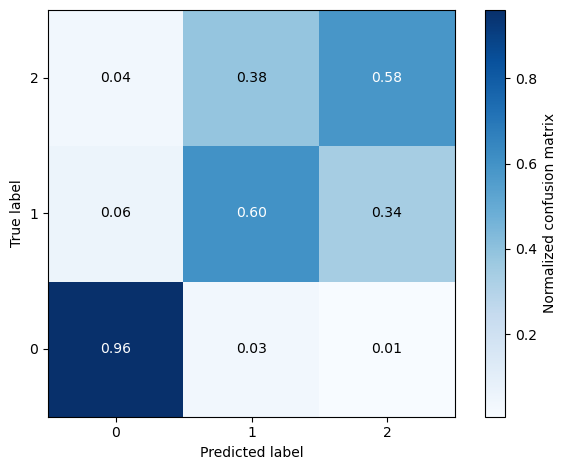

Epoch 17/50 - Learning Rate: 0.000090


Train Loss: 0.551498 | Val Loss: 0.412459 | Val Acc: 0.928 | Balanced Acc: 0.710
Epoch 17/50 took 309.69 seconds


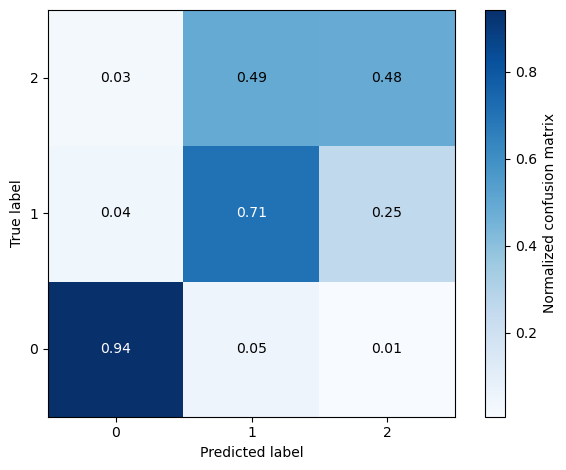

Epoch 18/50 - Learning Rate: 0.000089


Train Loss: 0.553232 | Val Loss: 0.378245 | Val Acc: 0.945 | Balanced Acc: 0.735
Epoch 18/50 took 309.28 seconds


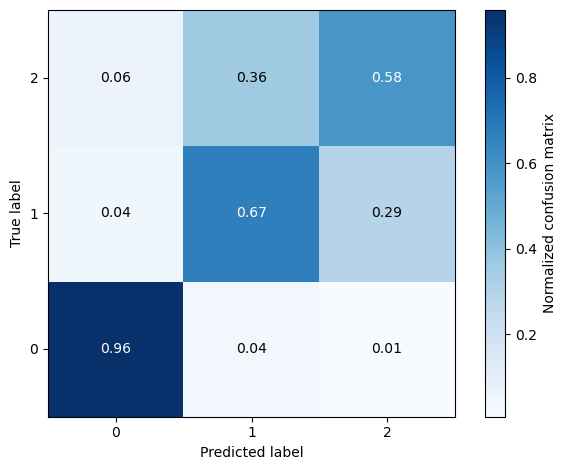

Epoch 19/50 - Learning Rate: 0.000087


Train Loss: 0.537938 | Val Loss: 0.394062 | Val Acc: 0.953 | Balanced Acc: 0.725
Epoch 19/50 took 309.31 seconds


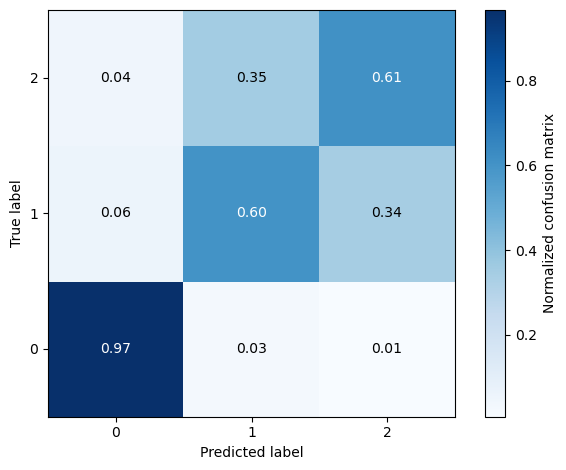

Epoch 20/50 - Learning Rate: 0.000085


Train Loss: 0.541861 | Val Loss: 0.383148 | Val Acc: 0.951 | Balanced Acc: 0.730
Epoch 20/50 took 309.10 seconds


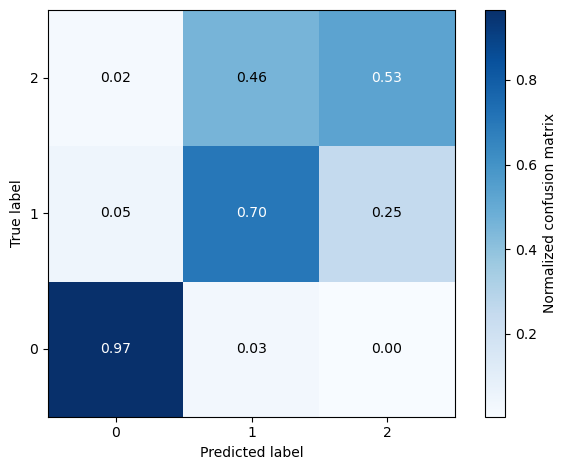

Epoch 21/50 - Learning Rate: 0.000084


Train Loss: 0.537839 | Val Loss: 0.379200 | Val Acc: 0.946 | Balanced Acc: 0.723
Epoch 21/50 took 309.33 seconds


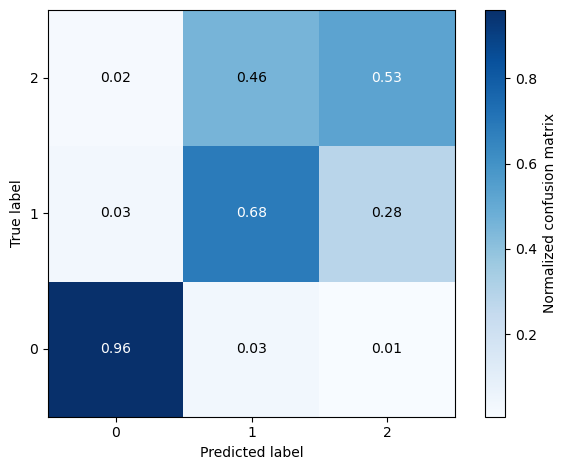

Epoch 22/50 - Learning Rate: 0.000082


Train Loss: 0.535608 | Val Loss: 0.372481 | Val Acc: 0.947 | Balanced Acc: 0.742
Epoch 22/50 took 309.33 seconds


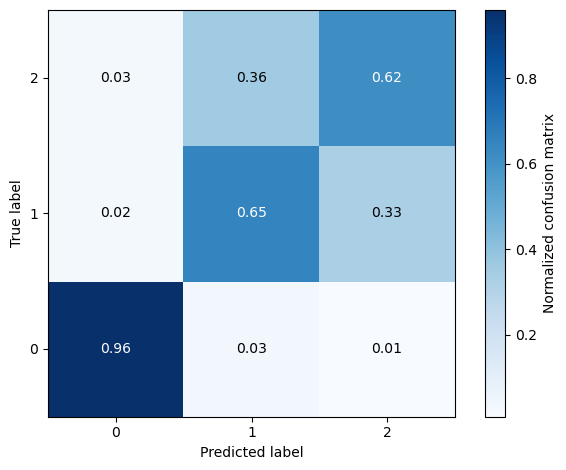

Epoch 23/50 - Learning Rate: 0.000080


Train Loss: 0.535523 | Val Loss: 0.401277 | Val Acc: 0.948 | Balanced Acc: 0.731
Epoch 23/50 took 309.24 seconds


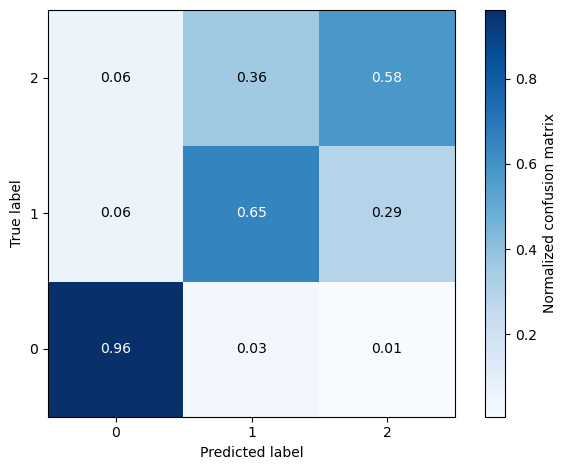

Epoch 24/50 - Learning Rate: 0.000078


Train Loss: 0.540144 | Val Loss: 0.374442 | Val Acc: 0.949 | Balanced Acc: 0.728
Epoch 24/50 took 309.37 seconds


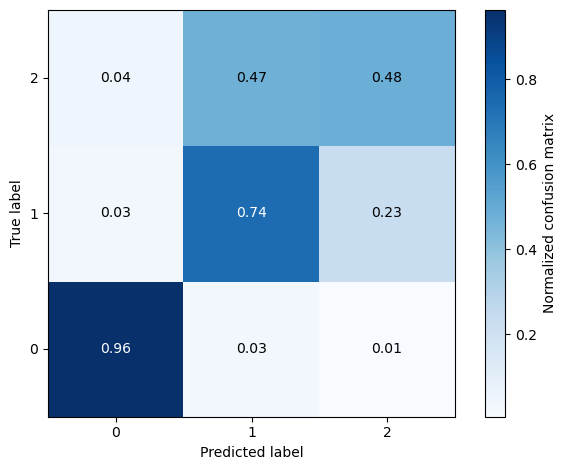

Epoch 25/50 - Learning Rate: 0.000076


Train Loss: 0.536662 | Val Loss: 0.369067 | Val Acc: 0.954 | Balanced Acc: 0.743
Epoch 25/50 took 309.39 seconds


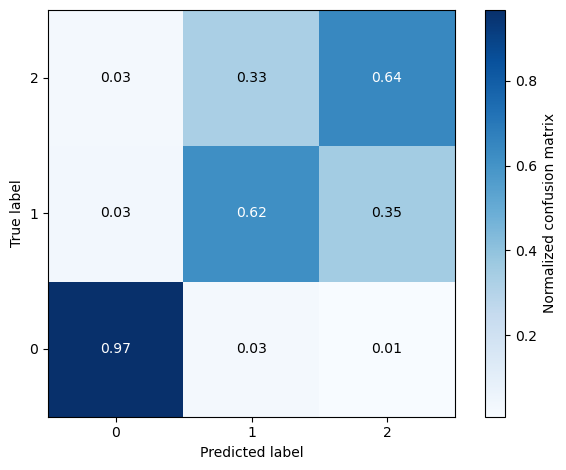

Epoch 26/50 - Learning Rate: 0.000074


Train Loss: 0.525091 | Val Loss: 0.372685 | Val Acc: 0.955 | Balanced Acc: 0.729
Epoch 26/50 took 309.50 seconds


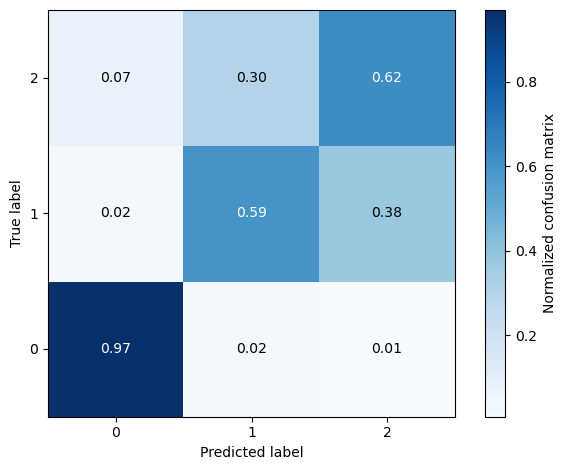

Epoch 27/50 - Learning Rate: 0.000071


Train Loss: 0.531825 | Val Loss: 0.384547 | Val Acc: 0.955 | Balanced Acc: 0.725
Epoch 27/50 took 309.32 seconds


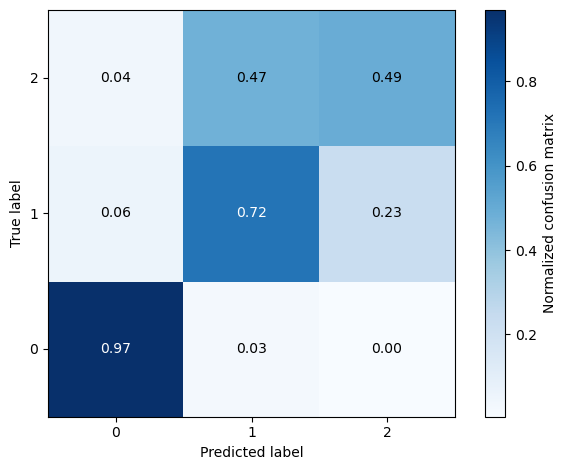

Epoch 28/50 - Learning Rate: 0.000069


Train Loss: 0.531107 | Val Loss: 0.383680 | Val Acc: 0.954 | Balanced Acc: 0.720
Epoch 28/50 took 309.92 seconds


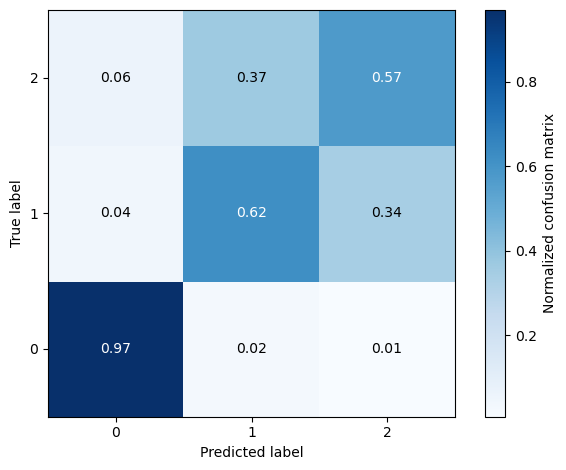

Epoch 29/50 - Learning Rate: 0.000067


Train Loss: 0.523589 | Val Loss: 0.360801 | Val Acc: 0.955 | Balanced Acc: 0.750
Epoch 29/50 took 309.71 seconds


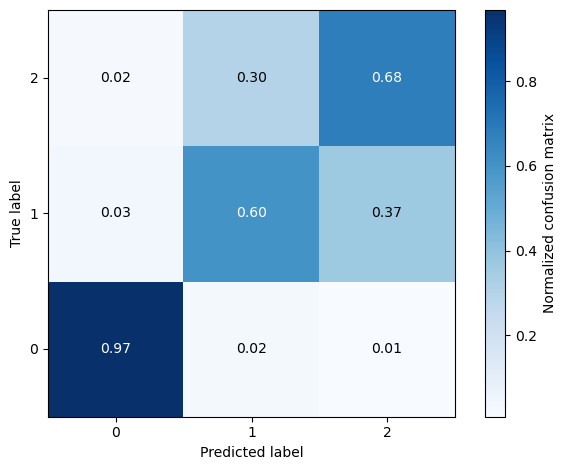

Epoch 30/50 - Learning Rate: 0.000064


Train Loss: 0.521261 | Val Loss: 0.372916 | Val Acc: 0.956 | Balanced Acc: 0.733
Epoch 30/50 took 312.59 seconds


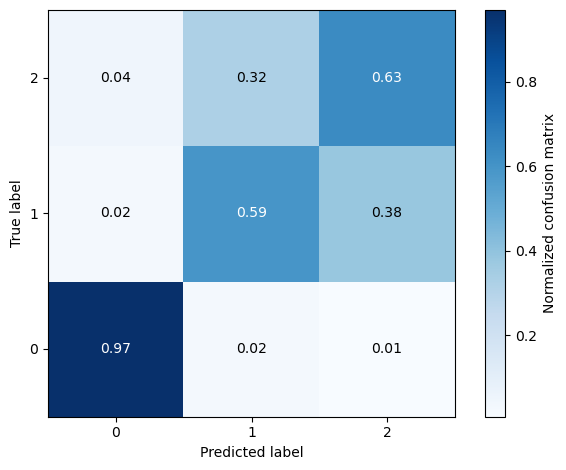

Epoch 31/50 - Learning Rate: 0.000061


Train Loss: 0.521927 | Val Loss: 0.353233 | Val Acc: 0.958 | Balanced Acc: 0.725
Epoch 31/50 took 309.86 seconds


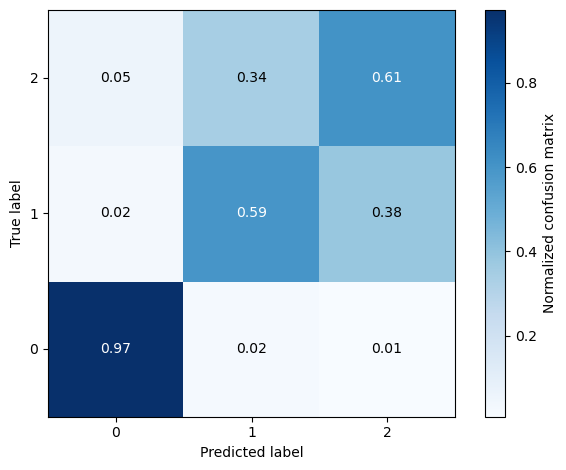

Epoch 32/50 - Learning Rate: 0.000059


Train Loss: 0.519459 | Val Loss: 0.367748 | Val Acc: 0.958 | Balanced Acc: 0.737
Epoch 32/50 took 309.42 seconds


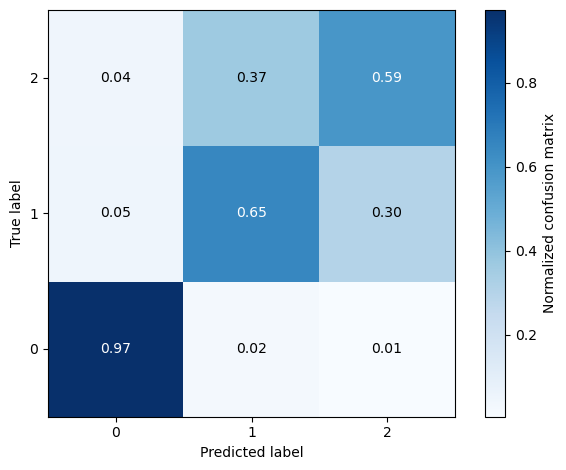

Epoch 33/50 - Learning Rate: 0.000056


Train Loss: 0.517985 | Val Loss: 0.360523 | Val Acc: 0.958 | Balanced Acc: 0.719
Epoch 33/50 took 309.27 seconds


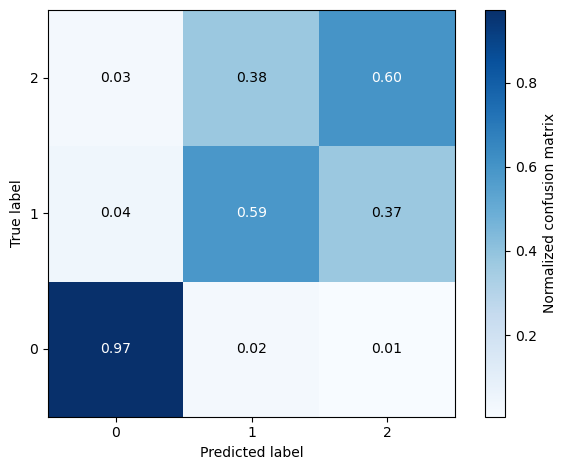

Epoch 34/50 - Learning Rate: 0.000053


Train Loss: 0.518151 | Val Loss: 0.348359 | Val Acc: 0.961 | Balanced Acc: 0.738
Epoch 34/50 took 309.13 seconds


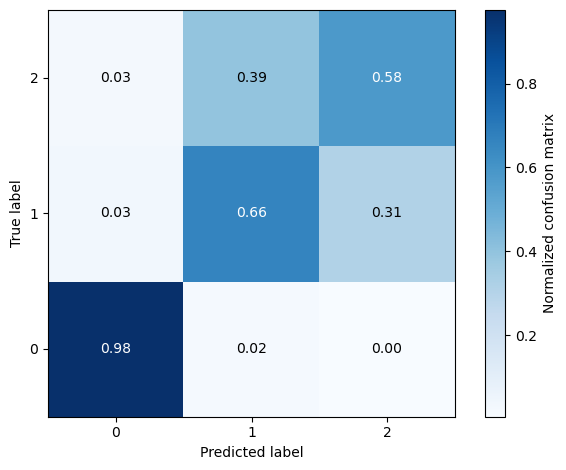

Epoch 35/50 - Learning Rate: 0.000050


Train Loss: 0.515894 | Val Loss: 0.367684 | Val Acc: 0.958 | Balanced Acc: 0.725
Epoch 35/50 took 309.28 seconds


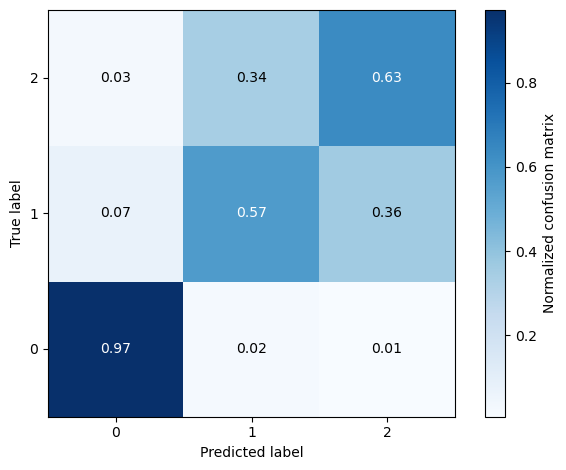

Epoch 36/50 - Learning Rate: 0.000048


Train Loss: 0.517987 | Val Loss: 0.356000 | Val Acc: 0.958 | Balanced Acc: 0.730
Epoch 36/50 took 309.31 seconds


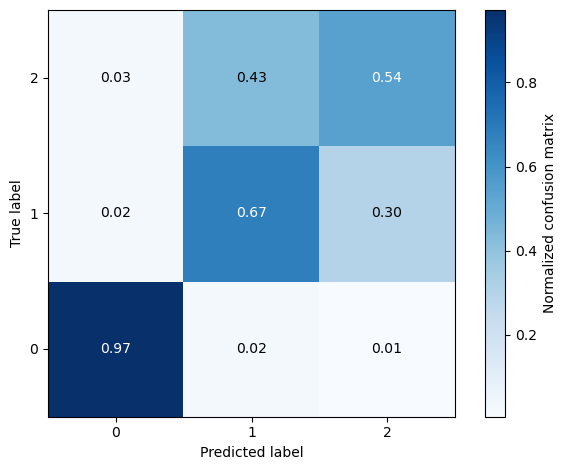

Epoch 37/50 - Learning Rate: 0.000045


Train Loss: 0.518624 | Val Loss: 0.345673 | Val Acc: 0.959 | Balanced Acc: 0.736
Epoch 37/50 took 309.15 seconds


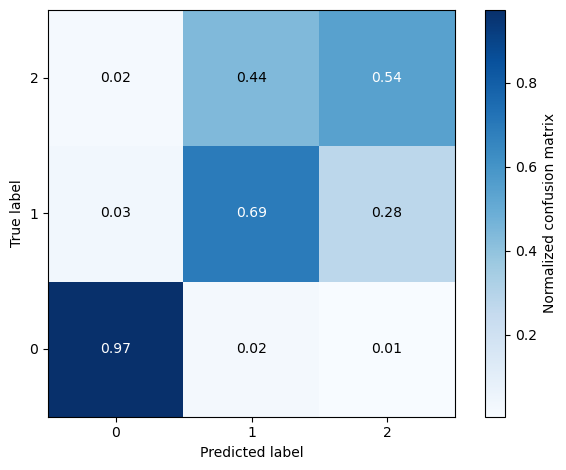

Epoch 38/50 - Learning Rate: 0.000042


Train Loss: 0.521411 | Val Loss: 0.347420 | Val Acc: 0.960 | Balanced Acc: 0.734
Epoch 38/50 took 309.16 seconds


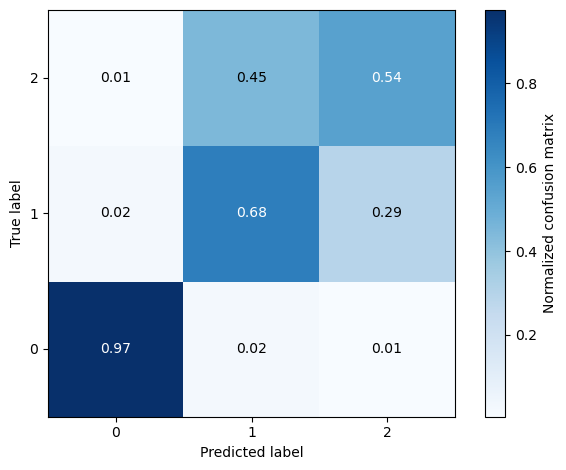

Epoch 39/50 - Learning Rate: 0.000039


Train Loss: 0.518593 | Val Loss: 0.341697 | Val Acc: 0.962 | Balanced Acc: 0.757
Epoch 39/50 took 309.49 seconds


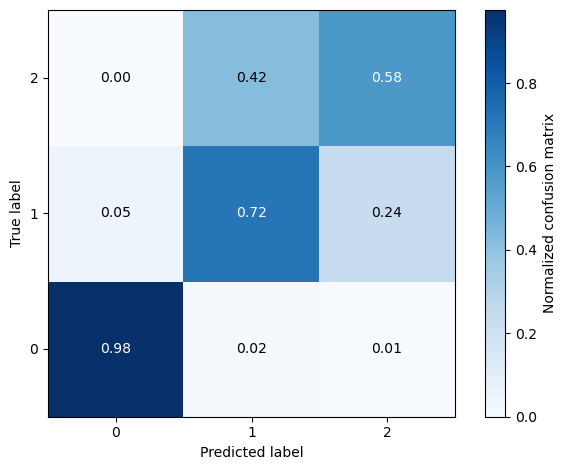

Epoch 40/50 - Learning Rate: 0.000036


Train Loss: 0.519147 | Val Loss: 0.354001 | Val Acc: 0.961 | Balanced Acc: 0.755
Epoch 40/50 took 309.36 seconds


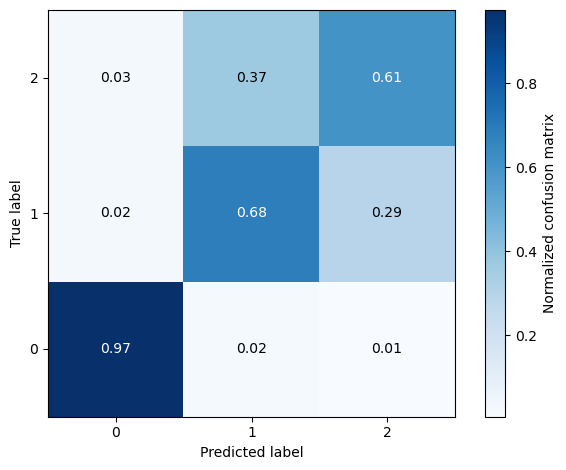

Epoch 41/50 - Learning Rate: 0.000032


Train Loss: 0.509515 | Val Loss: 0.343544 | Val Acc: 0.961 | Balanced Acc: 0.730
Epoch 41/50 took 310.15 seconds


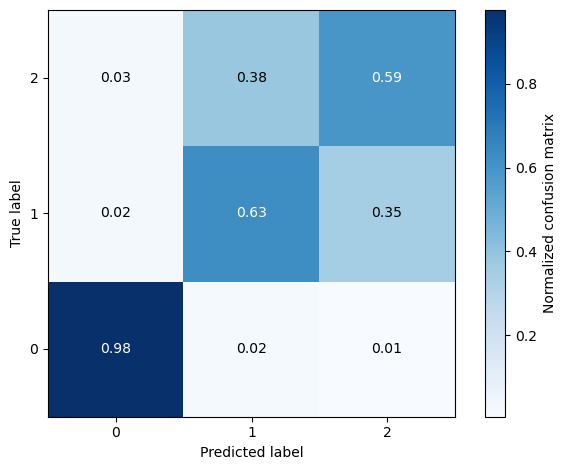

Epoch 42/50 - Learning Rate: 0.000029


Train Loss: 0.515924 | Val Loss: 0.349617 | Val Acc: 0.962 | Balanced Acc: 0.757
Epoch 42/50 took 309.19 seconds


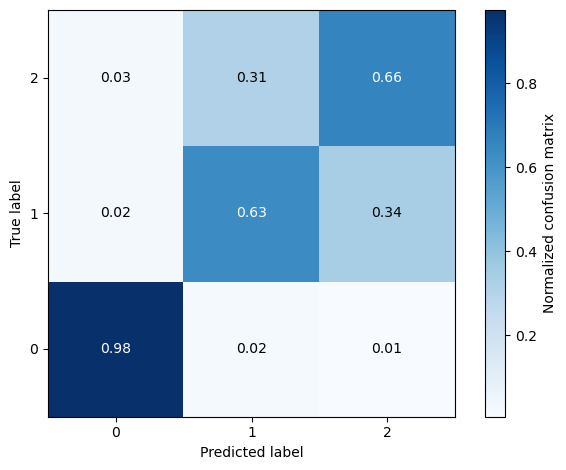

Epoch 43/50 - Learning Rate: 0.000026


Train Loss: 0.507786 | Val Loss: 0.352086 | Val Acc: 0.963 | Balanced Acc: 0.756
Epoch 43/50 took 310.19 seconds


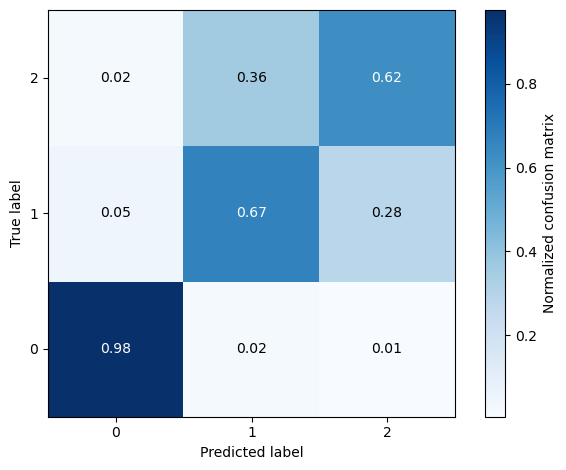

Epoch 44/50 - Learning Rate: 0.000023


Train Loss: 0.517518 | Val Loss: 0.344558 | Val Acc: 0.961 | Balanced Acc: 0.741
Epoch 44/50 took 309.27 seconds


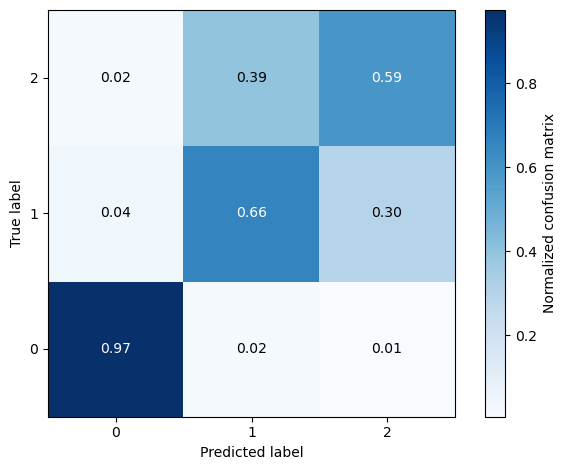

Epoch 45/50 - Learning Rate: 0.000020


Train Loss: 0.514361 | Val Loss: 0.354096 | Val Acc: 0.960 | Balanced Acc: 0.743
Epoch 45/50 took 309.53 seconds


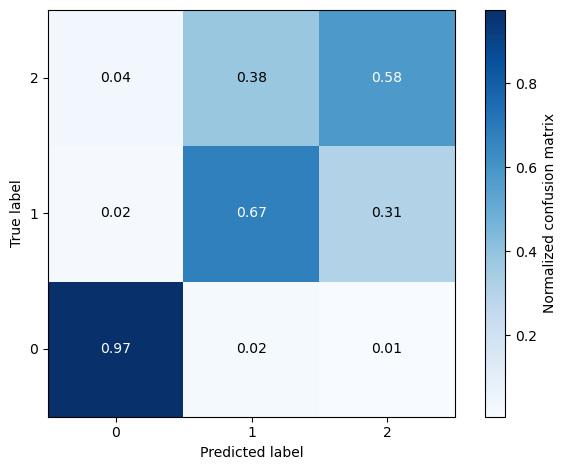

Epoch 46/50 - Learning Rate: 0.000016


Train Loss: 0.517441 | Val Loss: 0.364209 | Val Acc: 0.960 | Balanced Acc: 0.743
Epoch 46/50 took 309.25 seconds


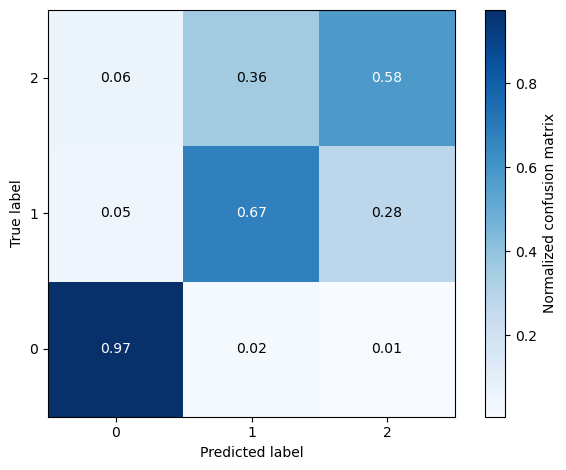

Epoch 47/50 - Learning Rate: 0.000013


Train Loss: 0.508331 | Val Loss: 0.348964 | Val Acc: 0.962 | Balanced Acc: 0.743
Epoch 47/50 took 309.68 seconds


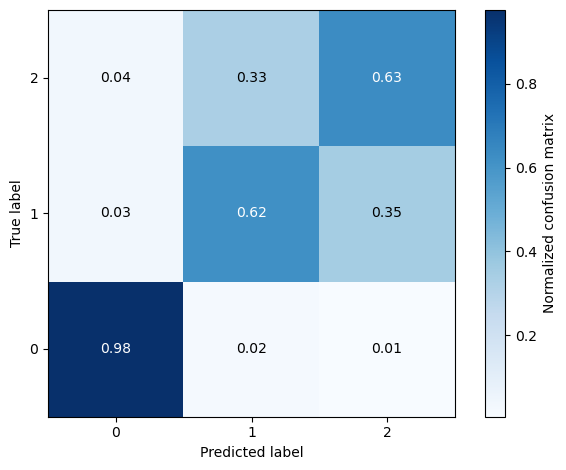

Epoch 48/50 - Learning Rate: 0.000010


Train Loss: 0.512218 | Val Loss: 0.347178 | Val Acc: 0.962 | Balanced Acc: 0.736
Epoch 48/50 took 309.19 seconds


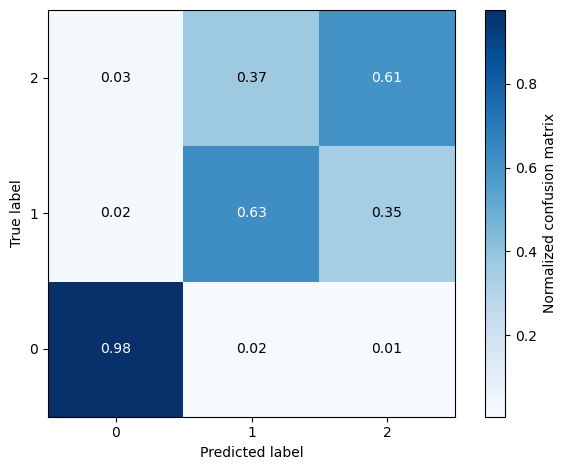

Epoch 49/50 - Learning Rate: 0.000007


Train Loss: 0.511090 | Val Loss: 0.351621 | Val Acc: 0.962 | Balanced Acc: 0.731
Epoch 49/50 took 309.36 seconds


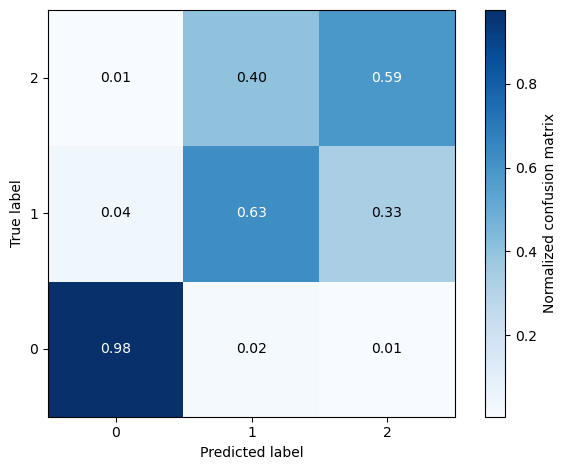

Epoch 50/50 - Learning Rate: 0.000003


Train Loss: 0.508482 | Val Loss: 0.356484 | Val Acc: 0.963 | Balanced Acc: 0.744
Epoch 50/50 took 309.27 seconds


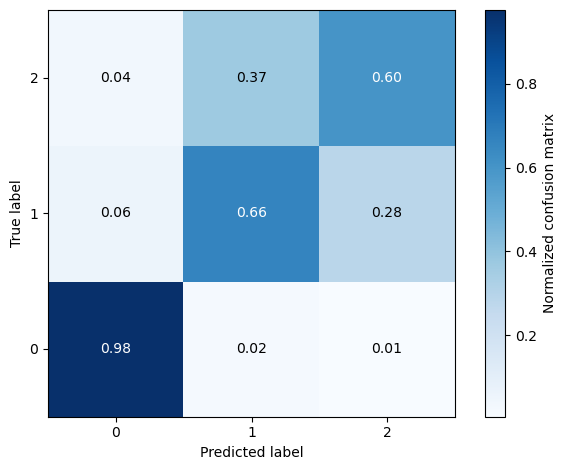

In [27]:
swin_multi_train_losses = []
swin_multi_val_losses = []

best_val_loss = np.inf
best_bal_acc = 0.5
best_combined_acc = 1

for epoch in range(epochs):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {current_lr:.6f}")

    train_loss = AF.training_epoch(swin_multi, swin_multi_train_loader, optimizer, criterion, device, scheduler = scheduler, unsqueezeY = False)
    val_loss, val_acc, all_preds, all_labels, bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_val_loader, criterion, device, desc = 'validation')

    # Step the scheduler
    #scheduler.step()

    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.3f} | Balanced Acc: {bal_acc:.3f}")

    swin_multi_train_losses.append(train_loss)
    swin_multi_val_losses.append(val_loss)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs} took {epoch_time:.2f} seconds")

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     torch.save(swin_multi.state_dict(), "swin_nonbinary_best_model.pth")

    if bal_acc > 0.7 or (bal_acc + val_acc) > 1.5:
        af.plot_confusion_matrix(all_labels, all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)
        plt.show()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(swin_multi.state_dict(), "deit3_nonbinary_best_model_val_loss.pth")
    
    if bal_acc > best_bal_acc:
        best_bal_acc = bal_acc
        torch.save(swin_multi.state_dict(), "deit3_nonbinary_best_model_bal_acc.pth")

    if bal_acc + val_acc > best_combined_acc:
        best_combined_acc = bal_acc + val_acc
        torch.save(swin_multi.state_dict(), "deit3_nonbinary_best_model_combined_acc.pth")

torch.save(swin_multi.state_dict(), "deit3_nonbinary_final_epoch_model.pth")

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

In [28]:
print(best_bal_acc, best_combined_acc)

0.7570016703257386 1.719159204572314


Text(0, 0.5, 'Loss')

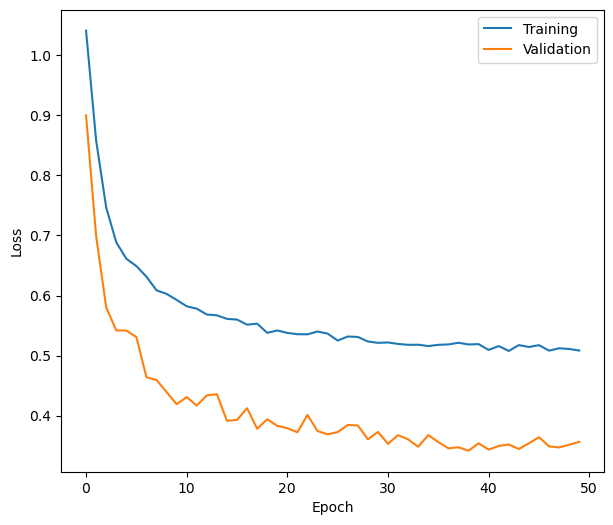

In [29]:
if epoch+1 == epochs:
    ep = epochs
else:
    ep = epoch
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(np.arange(ep), swin_multi_train_losses, label="Training")
ax.plot(np.arange(ep), swin_multi_val_losses, label="Validation")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [ ]:
swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi, swin_multi_test_loader,
                                                                                                                  criterion, device)

testing:  24%|█████████████████▋                                                        | 11/46 [00:22<01:05,  1.88s/it]

In [ ]:
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [39]:
swin_multi_combined_acc_model = timm.create_model('deit3_large_patch16_224', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_combined_acc_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_combined_acc_model.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_combined_acc_model = swin_multi_combined_acc_model.to(device)

0.963020030816641
0.7354606571632109


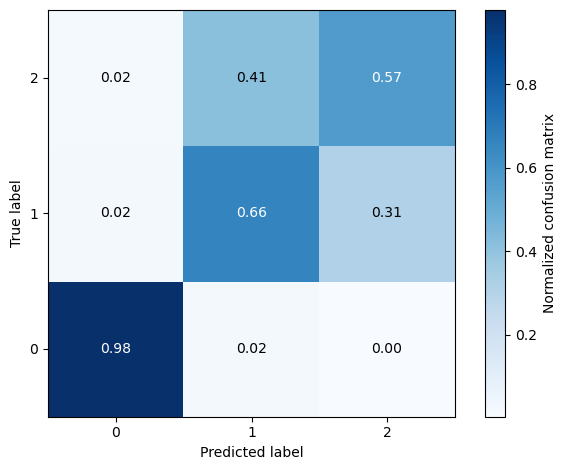

In [40]:
state_dict = torch.load("deit3_nonbinary_best_model_combined_acc.pth", map_location=device)
swin_multi_combined_acc_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_combined_acc_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=None, normalize=True, title=None, cmap=plt.cm.Blues)

In [35]:
swin_multi_bal_acc_model = timm.create_model('deit3_large_patch16_224', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_bal_acc_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_bal_acc_model.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_bal_acc_model = swin_multi_bal_acc_model.to(device)

0.965416880671118
0.7762433753652839


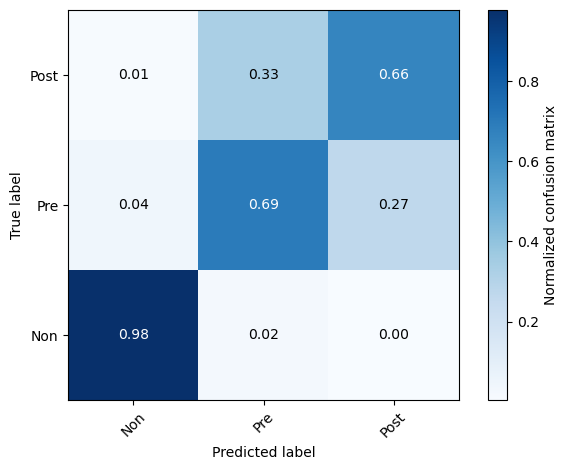

In [36]:
state_dict = torch.load("deit3_nonbinary_best_model_bal_acc.pth", map_location=device)
swin_multi_bal_acc_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_bal_acc_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=['Non','Pre','Post'], normalize=True, title=None, cmap=plt.cm.Blues)

In [37]:
swin_multi_val_loss_model = timm.create_model('deit3_large_patch16_224', pretrained=False, num_classes=3)

# Freeze all parameters first
for param in swin_multi_val_loss_model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in swin_multi_val_loss_model.head.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin_multi_val_loss_model = swin_multi_val_loss_model.to(device)

0.9635336414997432
0.7422658494522741


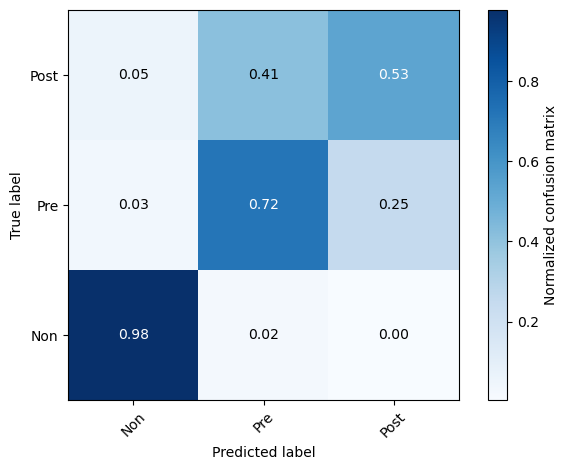

In [38]:
state_dict = torch.load("deit3_nonbinary_best_model_val_loss.pth", map_location=device)
swin_multi_val_loss_model.load_state_dict(state_dict)

swin_multi_epoch_loss, swin_multi_epoch_acc, swin_multi_all_preds, swin_multi_all_labels, swin_multi_bal_acc = AF.nonbinary_multilabel_evaluate(swin_multi_val_loss_model, swin_multi_test_loader,
                                                                                                                  criterion, device)
print(swin_multi_epoch_acc)
print(swin_multi_bal_acc)
af.plot_confusion_matrix(swin_multi_all_labels, swin_multi_all_preds, classes=['Non','Pre','Post'], normalize=True, title=None, cmap=plt.cm.Blues)